# Project 1: Cyclic Coordinate Descent for Regularized Logistic Regression

## Datasets

dataset1

dataset2

dataset3

dataset4

dataset_synthetic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [21]:
class LogRegCCD(): 
    """
    **DESCRIPTION**
    """
    def __init__(self, scaler=StandardScaler(), seed=42,): 
        self.optimized = False
        self.scaler = scaler
        self.seed = seed


    def __sigmoid(self, x): 
            return 1 / (1 + np.exp(-x))
    
    def __standarize(self, X, standarize=True):  
        return pd.DataFrame(self.scaler.fit_transform(X)) if standarize else X
        
        

    def single_fit(self, X_train, y_train, lambda_=0.01, nr_iter=100, standarize=True, tol=1e-3): 
        def compute_cost(X_train, y_train, lambda_):
            n = len(y_train)
            y_dash = X_train @ self.beta + self.beta_zero
            p = self.__sigmoid(y_dash)
            cost = - (1/n) * np.sum(y_train * np.log(p) + (1 - y_train) * np.log(1 - p))
            reg_term = lambda_ * np.sum(np.abs(self.beta)) / n  # L1 regularization
            return cost + reg_term
        
        def soft_threshold(a, b):
            return np.sign(a) * np.maximum(np.abs(a) - b, 0)
                  
        def calculate_coordinate_descent(X_train, y_train, lambda_, j): 
            y_dash = X_train @ self.beta + self.beta_zero
            p = self.__sigmoid(y_dash)
            p = np.clip(p, 1e-5, 1 - 1e-5)
            w = p * (1 - p)
            z = y_dash + (y_train - p) / w
            # self.beta_zero = np.sum(w * z) / np.sum(w)

            residual = z - y_dash + self.beta[j] * X_train.iloc[:, j]
            st_nom = np.sum(w * X_train.iloc[:, j] * residual)

            st_denom = np.sum(w * X_train.iloc[:, j] ** 2)

            return w, z, soft_threshold(st_nom, lambda_)/st_denom
        
        np.random.seed(self.seed)
        X_train = self.__standarize(X_train, standarize)
        g = X_train.shape[1]
        
        
        self.beta_zero = 0
        self.beta = np.zeros(g)
        self.lambda_ = lambda_


        for i in range(nr_iter): 
            beta_old = self.beta.copy()
            for j in range(g): 
                w, z, beta_j = calculate_coordinate_descent(X_train, y_train, lambda_, j)
                self.beta[j] = beta_j
            self.beta_zero = np.sum(w * z) / np.sum(w)
            # Convergence check
            if np.linalg.norm(self.beta - beta_old, ord=1) < tol:
                break

        self.cost = compute_cost(X_train, y_train, lambda_)
        return self
        
    



    def validate(self, X_valid, y_valid, measure, standarize=True): 
        """
        **DESCRIPTION**

        Parameters
        ----------
        X_valid:

        y_valid:

        measure: 

        Returns
        -------
        

        """
        X_valid = self.__standarize(X_valid, standarize)
        # Get predicted probabilities
        y_prob = self.predict_proba(X_valid, standarize=False)

        # Convert probabilities to binary predictions 
        y_pred = (y_prob >= 0.5).astype(int)

        # Compute the performance measure
        score = measure(y_valid, y_pred)
        return score

    def predict_proba(self, X_test, standarize=True): 
        """
        **DESCRIPTION**

        Parameters
        ----------
        X_test: 

        Returns
        -------
        

        """
        X_test = self.__standarize(X_test, standarize)
        return self.__sigmoid(X_test.dot(self.beta) + self.beta_zero)
        

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, eps=0.001, K=10, measure=accuracy_score, nr_iter=100, standarize=True, tol=1e-3):
        
        X_train = self.__standarize(X_train, standarize)

        if X_valid is None and y_valid is None:
            X_valid = X_train
            y_valid = y_train
        else: 
            X_valid = self.__standarize(X_valid, standarize)

        n = len(y_train)
        # Compute lambda_max = max_l |<x_l, y>| / n (from paper)

        inner_products = np.abs(np.dot(X_train.T, y_train)) / 4
        lambda_max = inner_products.max()
        lambda_min = eps * lambda_max
        
        lambdas = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_min), K))
        # lambdas = np.exp(np.linspace(lambda_max, lambda_min, K))
        
        betas = []
        betas_zero = []
        # costs = []
        scores = []
        
        for lam in lambdas:
            self.single_fit(X_train, y_train, lambda_=lam, nr_iter=nr_iter, standarize=False, tol=tol)
            betas.append(self.beta.tolist())
            betas_zero.append(self.beta_zero)
            # costs.append(self.cost)
            score = self.validate(X_valid, y_valid, measure, standarize=False)
            scores.append(score)
            
        
        p = X_train.shape[1]
        columns = [f"Beta_{i + 1}" for i in range(p)]
        self.coeffs_df = pd.DataFrame(betas, columns=columns)
        self.coeffs_df['Intercept'] = betas_zero
        self.coeffs_df['Lambda'] = lambdas
        # self.coeffs_df['Cost'] = costs
        self.coeffs_df['ValidationScore'] = scores
        
        best_idx = np.argmax(scores)
        self.lambda_ = lambdas[best_idx]
        self.beta = betas[best_idx]
        self.beta_zero = betas_zero[best_idx]
        self.score = scores[best_idx]
        return self

    def plot_coeff(self):
        """
        Plot the coefficient values vs. log(Lambda)
        """
        
        plt.figure(figsize=(10, 6))
        log_lambda = np.log(self.coeffs_df['Lambda'])

        for col in self.coeffs_df.columns:
            if col not in ['Lambda', 'ValidationScore', 'Intercept']:
                plt.plot(log_lambda, self.coeffs_df[col], marker='o', color='blue', linewidth=1)
        
        plt.xlabel("log(Lambda)")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient values vs. log(Lambda)")
        plt.tight_layout()
        plt.show()

    def plot_score(self):
        """
        Runs fit_optimize_lambda with the provided measure, then plots the validation score vs. log(Lambda).
        """
      
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(self.coeffs_df['Lambda']), self.coeffs_df['ValidationScore'],
                 marker='o', color='blue', linewidth=2)
        plt.xlabel("log(Lambda)")
        plt.ylabel("Validation Score")
        plt.title("Validation Score vs. log(Lambda)\nBest lambda: {:.4f} with score {:.4f}".format(self.lambda_, self.score))
        plt.tight_layout()
        plt.show()
        
        return self.lambda_, self.score



In [14]:
tecator_X_stand = pd.DataFrame(StandardScaler().fit_transform(tecator_X))
inner_products = np.abs(tecator_X_stand.T @ tecator_y) / 4
lambda_max = inner_products.max()
lambda_min = 0.001 * lambda_max

np.exp(np.linspace(np.log(lambda_max), np.log(lambda_min), 10))

array([2.25533372e+01, 1.04683318e+01, 4.85896920e+00, 2.25533372e+00,
       1.04683318e+00, 4.85896920e-01, 2.25533372e-01, 1.04683318e-01,
       4.85896920e-02, 2.25533372e-02])

In [15]:
logRegCCDs = LogRegCCD()
logRegCCDs = logRegCCDs.single_fit(tecator_X_stand, tecator_y, lambda_=2.25533372e+01, nr_iter=100, standarize=False)
logRegCCDs.beta

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [119]:
inner_products

array([1.22370137e+00, 1.22467833e+00, 1.22568229e+00, 1.22673008e+00,
       1.22785050e+00, 1.22907792e+00, 1.23044250e+00, 1.23196446e+00,
       1.23365317e+00, 1.23553571e+00, 1.23759808e+00, 1.23986092e+00,
       1.24236042e+00, 1.24513696e+00, 1.24822392e+00, 1.25162954e+00,
       1.25535029e+00, 1.25941904e+00, 1.26385496e+00, 1.26862408e+00,
       1.27361188e+00, 1.27861829e+00, 1.28344592e+00, 1.28799113e+00,
       1.29229363e+00, 1.29652667e+00, 1.30099279e+00, 1.30603229e+00,
       1.31188342e+00, 1.31862071e+00, 1.32607458e+00, 1.33388825e+00,
       1.34170450e+00, 1.34939262e+00, 1.35714579e+00, 1.36535954e+00,
       1.37437725e+00, 1.38405333e+00, 1.39390804e+00, 1.40325396e+00,
       1.41130225e+00, 1.41736617e+00, 1.42113725e+00, 1.42287675e+00,
       1.42344662e+00, 1.42411317e+00, 1.42621425e+00, 1.43106900e+00,
       1.43926071e+00, 1.45110283e+00, 1.46658629e+00, 1.48522563e+00,
       1.50593712e+00, 1.52703921e+00, 1.54661537e+00, 1.56309033e+00,
      

In [17]:
def evaluate_performance(logRegCCD, X, y): 
    # print("Beta: ", logRegCCD.beta)
    # print("Beta zero: ", logRegCCD.beta_zero)

    # print("-----------------")

    print("Accuracy score: ", logRegCCD.validate(X, y, accuracy_score))
    print("Precision score: ", logRegCCD.validate(X, y, precision_score))
    print("Recall score: ", logRegCCD.validate(X, y, recall_score))
    print("F-measure score: ", logRegCCD.validate(X, y, f1_score))
    print("Balanced Accuracy score: ", logRegCCD.validate(X, y, balanced_accuracy_score))
    print("AUC-ROC score: ", logRegCCD.validate(X, y, roc_auc_score))
    print("AUC-PR: score: ", logRegCCD.validate(X, y, average_precision_score))

## dataset1

In [18]:
tecator_data = pd.read_csv("data/tecator.csv", header=None)
tecator_X = tecator_data.iloc[:, :-1]
tecator_y = (tecator_data.iloc[:, -1] == 'P').astype(int)

print(tecator_X.shape)
print("Target distribution (P as 1, N as 0):", sum(tecator_y) / len(tecator_y))
print(tecator_X.head())


(240, 124)
Target distribution (P as 1, N as 0): 0.425
       0        1        2        3        4        5        6        7    \
0  2.61776  2.61814  2.61859  2.61912  2.61981  2.62071  2.62186  2.62334   
1  2.83454  2.83871  2.84283  2.84705  2.85138  2.85587  2.86060  2.86566   
2  2.58284  2.58458  2.58629  2.58808  2.58996  2.59192  2.59401  2.59627   
3  2.82286  2.82460  2.82630  2.82814  2.83001  2.83192  2.83392  2.83606   
4  2.78813  2.78989  2.79167  2.79350  2.79538  2.79746  2.79984  2.80254   

       8        9    ...       114       115       116       117       118  \
0  2.62511  2.62722  ...  0.296029  0.233876  0.899661 -0.042006  0.708717   
1  2.87093  2.87661  ... -0.454959 -0.195980 -0.046359 -0.634996 -0.354403   
2  2.59873  2.60131  ...  0.628166  0.795466  0.762246 -1.268580  0.690588   
3  2.83842  2.84097  ...  0.281853  0.616500 -0.388684 -2.068390  1.276160   
4  2.80553  2.80890  ...  0.703580 -1.095540 -1.348450  0.453559  0.402624   

        119  

Accuracy score:  0.9958333333333333
Precision score:  1.0
Recall score:  0.9901960784313726
F-measure score:  0.9950738916256158
Balanced Accuracy score:  0.9950980392156863
AUC-ROC score:  0.9950980392156863
AUC-PR: score:  0.9943627450980392


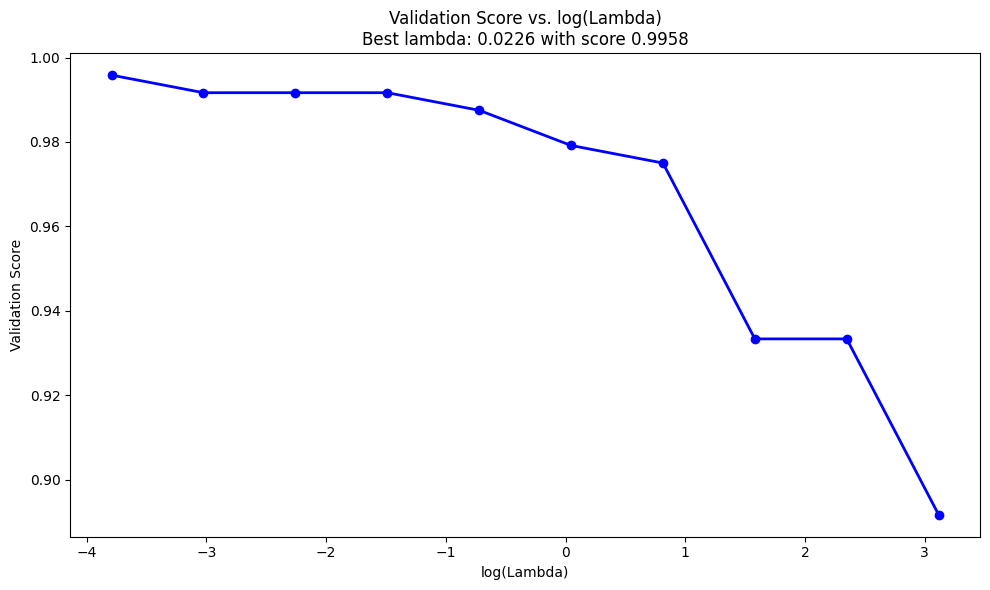

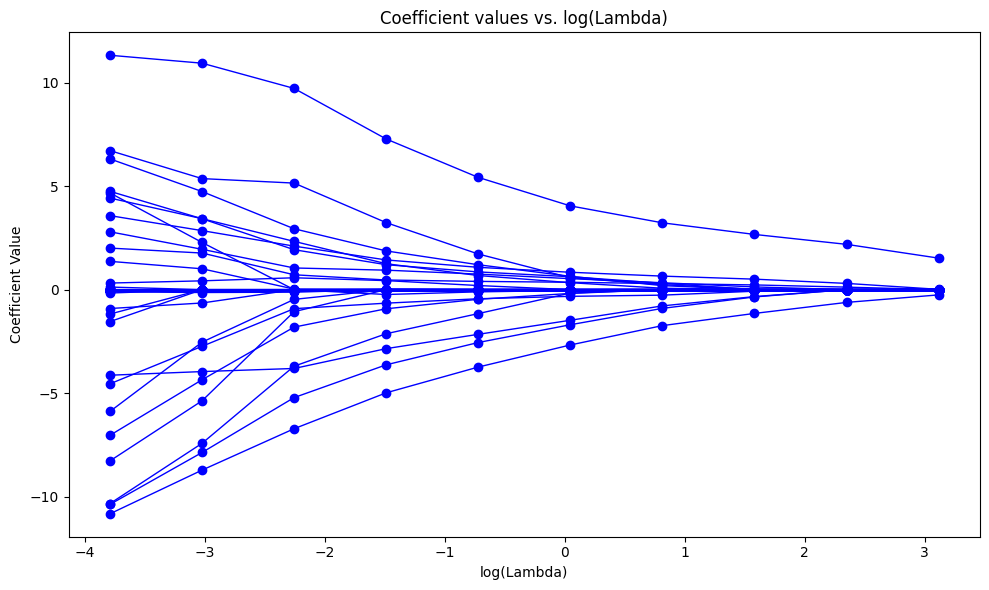

In [19]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(tecator_X, tecator_y)

evaluate_performance(logRegCCD, tecator_X, tecator_y)
logRegCCD.plot_score()
logRegCCD.plot_coeff()

In [ ]:
logRegCCD.plot_score()
logRegCCD.plot_coeff()

In [141]:
logRegCCD.coeffs_df

,Beta_1,Beta_2,Beta_3,Beta_4,Beta_5,Beta_6,Beta_7,Beta_8,Beta_9,Beta_10,...,Beta_118,Beta_119,Beta_120,Beta_121,Beta_122,Beta_123,Beta_124,Intercept,Lambda,ValidationScore
0,-0.689239,-0.009030,-0.002784,-0.002585,-0.002396,-0.002181,-0.001883,-0.001546,-0.001565,-0.000993,...,0.640431,0.357900,-0.027658,-0.315275,0.099153,-1.942313,1.358393,-0.373550,0.375889,0.958333
1,-0.761994,-0.010142,-0.002780,-0.002587,-0.004727,-0.004252,-0.003422,-0.002505,-0.001763,-0.001004,...,0.657244,0.434886,-0.040145,-0.332290,0.193610,-2.035236,1.405240,-0.347030,0.174472,0.958333
2,-0.796188,-0.011305,-0.003049,-0.005432,-0.004903,-0.004255,-0.003425,-0.002509,-0.001769,-0.001009,...,0.665425,0.470744,-0.029365,-0.352618,0.235320,-2.080175,1.428191,-0.339137,0.080983,0.958333
3,-0.812311,-0.011932,-0.004576,-0.005432,-0.004905,-0.004256,-0.003427,-0.002512,-0.001773,-0.001013,...,0.669280,0.487599,-0.023576,-0.362730,0.254918,-2.102228,1.439405,-0.335453,0.037589,0.958333
4,-0.819867,-0.012237,-0.005285,-0.005432,-0.004905,-0.004257,-0.003428,-0.002513,-0.001774,-0.001014,...,0.671056,0.495449,-0.020878,-0.367458,0.264105,-2.112759,1.444753,-0.333743,0.017447,0.958333
5,-0.823389,-0.012381,-0.005614,-0.005432,-0.004906,-0.004258,-0.003429,-0.002514,-0.001775,-0.001015,...,0.671885,0.499102,-0.019623,-0.369661,0.268390,-2.117695,1.447263,-0.332942,0.008098,0.958333
6,-0.825028,-0.012449,-0.005767,-0.005432,-0.004906,-0.004258,-0.003429,-0.002514,-0.001775,-0.000942,...,0.672269,0.500799,-0.019040,-0.370685,0.270383,-2.120000,1.448434,-0.332569,0.003759,0.958333
7,-0.825789,-0.012481,-0.005838,-0.005432,-0.004906,-0.004258,-0.003429,-0.002515,-0.001775,-0.000872,...,0.672447,0.501587,-0.018770,-0.371161,0.271309,-2.121072,1.448980,-0.332396,0.001745,0.958333
8,-0.826142,-0.012495,-0.005871,-0.005432,-0.004906,-0.004258,-0.003429,-0.002515,-0.001776,-0.000839,...,0.672530,0.501953,-0.018644,-0.371382,0.271739,-2.121570,1.449233,-0.332316,0.000810,0.958333
9,-0.826306,-0.012502,-0.005886,-0.005432,-0.004906,-0.004258,-0.003429,-0.002515,-0.001776,-0.000824,...,0.672569,0.502122,-0.018586,-0.371485,0.271939,-2.121801,1.449351,-0.332279,0.000376,0.958333


## dataset2

In [20]:
sonar_data = pd.read_csv("data/sonar.csv", header=None)
sonar_X = sonar_data.iloc[:, :-1]
sonar_y = (sonar_data.iloc[:, -1] == 'Mine').astype(int)

print(sonar_X.shape)
print("Target distribution:", sum(sonar_y) / len(sonar_y))
print(sonar_X.head())

(208, 60)
Target distribution: 0.5336538461538461
       0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      50      51      52      53      54      55      56  \
0  0.2111  ...  0.0232  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180   
1  0.2872  ...  0.0125  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140   
2  0.6194  ...  0.0033  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316   
3  0.1264  ...  0.0241  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050   
4  0.4459  ...  0.0156  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072   

       57      58      59  
0  0.0084  0.0

In [22]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(sonar_X, sonar_y)

evaluate_performance(logRegCCD, sonar_X, sonar_y)

Accuracy score:  0.9663461538461539
Precision score:  0.9905660377358491
Recall score:  0.9459459459459459
F-measure score:  0.967741935483871
Balanced Accuracy score:  0.9678183337977153
AUC-ROC score:  0.9678183337977153
AUC-PR: score:  0.9658680814341192


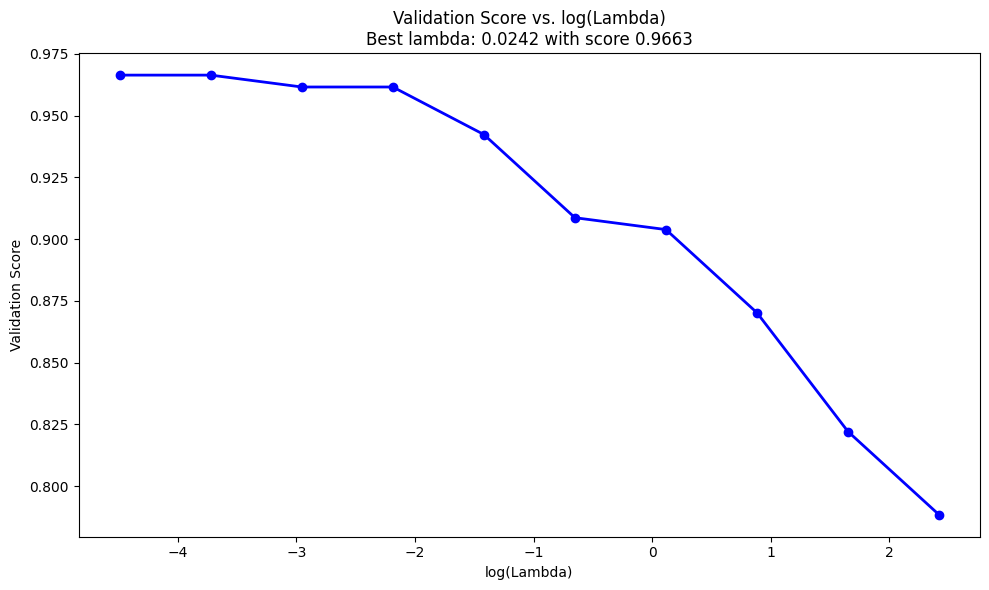

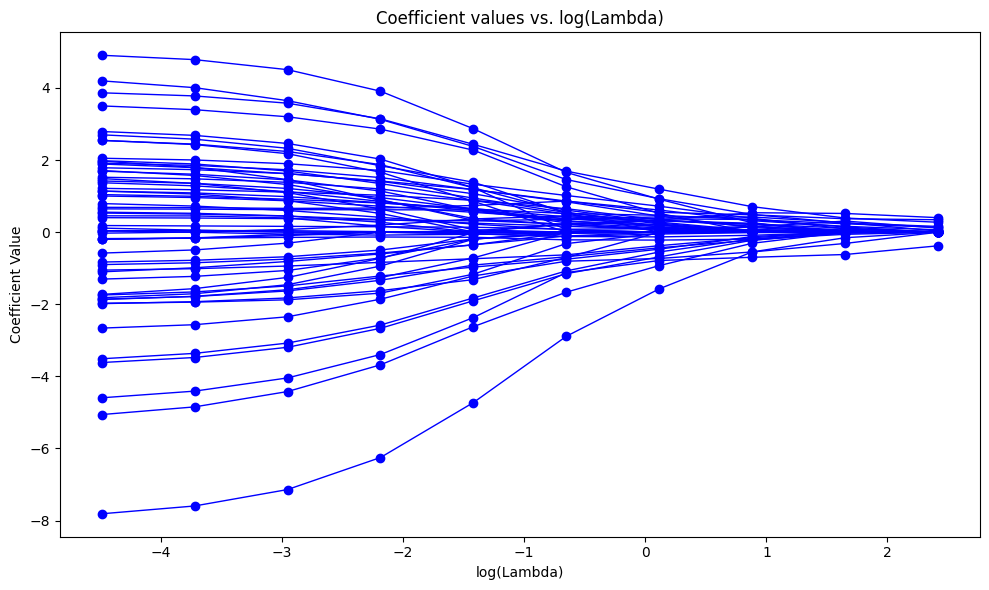

In [24]:
logRegCCD.plot_score()
logRegCCD.plot_coeff()

In [99]:
# what a weird plots

## dataset3

## dataset4

## Synthetic dataset

In [31]:
def generate_synthetic_data(p, n, d, g, seed=42):
    """
    Generate a synthetic dataset based on the given parameters.
    
    Parameters
    ----------
        p: float
            Prior probability for class Y=1.
        n: int
            Number of observations.
        d:  int
            Dimensionality of feature space.
        g: float 
            Covariance decay factor.
    
    Returns
    ----------
        DataFrame: A DataFrame containing generated features and class labels.
    """
    np.random.seed(seed)
    # Generate binry class variable
    y = np.random.binomial(1, p, size=n)

    # Define means for multivariate normal distribution
    mean_0 = np.zeros(d)
    mean_1 = np.array([1 / (i + 1) for i in range(d)])

    # Define covariance matrix S
    indices = np.arange(d)
    S = np.array([[g ** np.abs(i - j) for j in indices] for i in indices])
    
    # Create DataFrame
    X = np.array([
        np.random.multivariate_normal(mean_1 if y_id == 1 else mean_0, S)
        for y_id in y
    ])
    columns = [f'X{i+1}' for i in range(d)]
    X = pd.DataFrame(X, columns=columns)
    
    return X, y


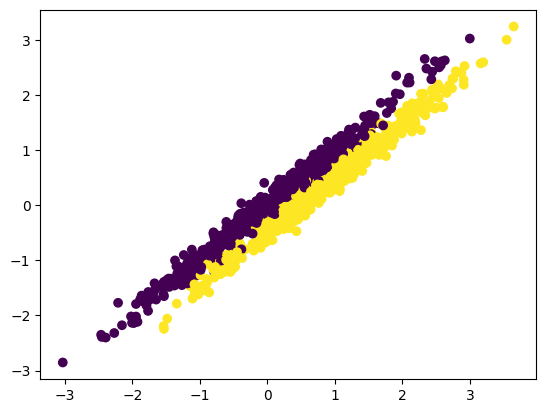

In [32]:
np.random.seed(42)
p = 0.5
n = 1000
d = 2
g = 0.99

synthetic_X, synthetic_y = generate_synthetic_data(p, n, d, g)
plt.scatter(synthetic_X["X1"], synthetic_X["X2"], c=synthetic_y)
plt.show()

Accuracy score:  0.964
Precision score:  0.9637826961770624
Recall score:  0.9637826961770624
F-measure score:  0.9637826961770624
Balanced Accuracy score:  0.9639987039533423
AUC-ROC score:  0.9639987039533423
AUC-PR: score:  0.9468770854503277


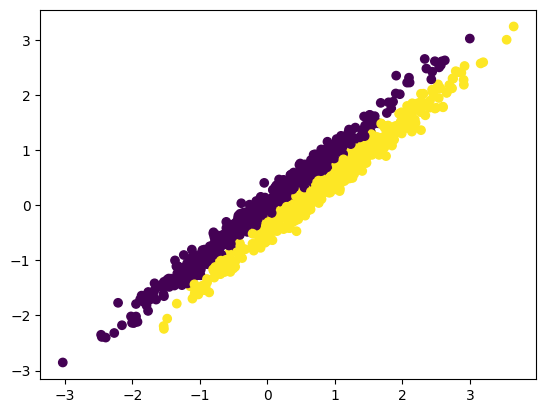

In [33]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(synthetic_X, synthetic_y)
# Get predicted probabilities
y_prob_syn = logRegCCD.predict_proba(synthetic_X)

evaluate_performance(logRegCCD, synthetic_X, synthetic_y)

y_pred_syn = (y_prob_syn >= 0.5).astype(int)
plt.scatter(synthetic_X.iloc[:,0], synthetic_X.iloc[:,1], c=y_pred_syn)
plt.show()

Accuracy:  0.966
Beta:  [[ 24.79054453 -24.10764711]]
Beta zero:  [-6.05152384]


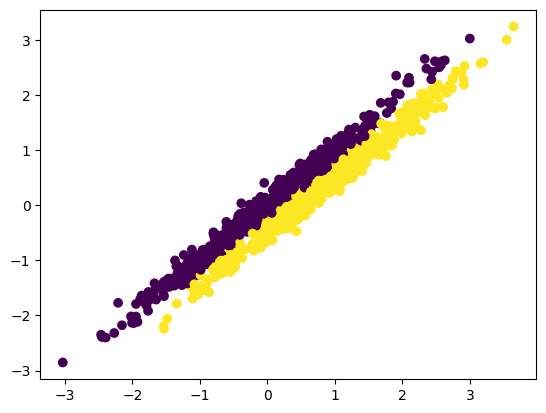

In [34]:
clf = LogisticRegression(random_state=42, penalty='none').fit(synthetic_X, synthetic_y)
print("Accuracy: ", clf.score(synthetic_X, synthetic_y))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)
y_pred_lg = clf.predict(synthetic_X)
plt.scatter(synthetic_X.iloc[:,0], synthetic_X.iloc[:,1], c=y_pred_lg)
plt.show()

In [35]:
np.random.seed(42)
p = 0.5
n = 100
d = 200
g = 0.90

synthetic_X, synthetic_y = generate_synthetic_data(p, n, d, g)

logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(synthetic_X, synthetic_y)

evaluate_performance(logRegCCD, synthetic_X, synthetic_y)

Accuracy score:  0.97
Precision score:  0.9782608695652174
Recall score:  0.9574468085106383
F-measure score:  0.967741935483871
Balanced Accuracy score:  0.9692894419911682
AUC-ROC score:  0.9692894419911683
AUC-PR: score:  0.9566327474560593


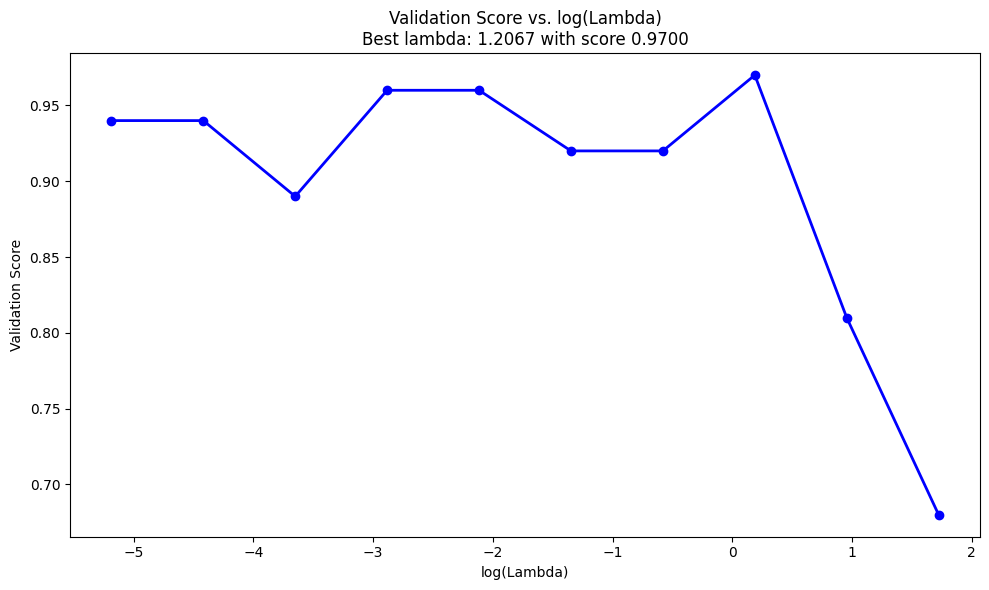

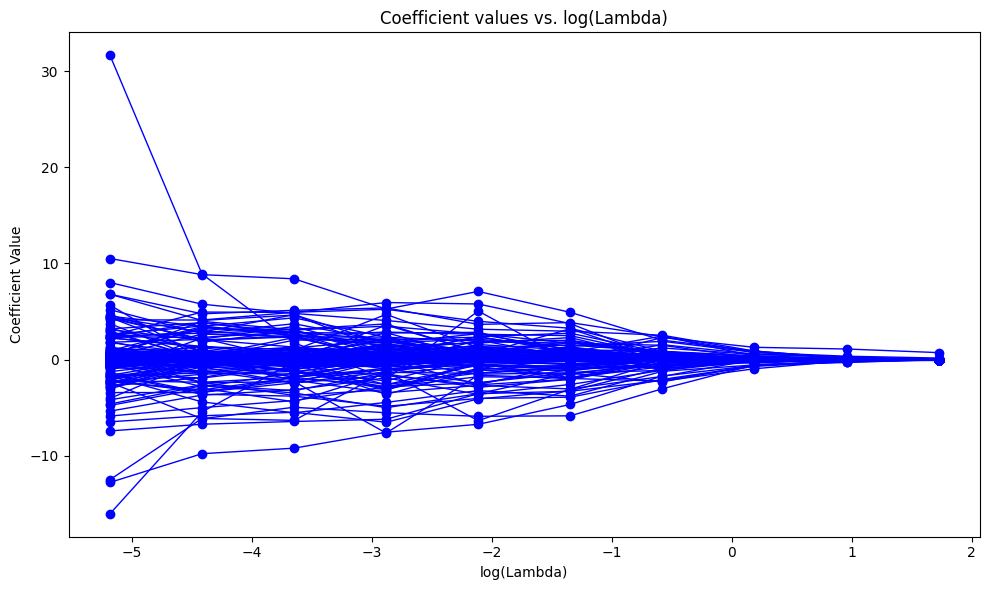

In [36]:
logRegCCD.plot_score()
logRegCCD.plot_coeff()

## predict_students_dropout_and_academic_success

In [25]:
student_dropout_X = pd.read_csv("./data/predict_students_dropout_and_academic_success/data.csv", sep=";")
student_dropout_y = (student_dropout_X['Target'] == 'Graduate').astype(int)
student_dropout_X.drop("Target", inplace=True, axis=1)
print(student_dropout_X.shape)
print("Graduated: ", sum(student_dropout_y)/len(student_dropout_y))
student_dropout_X.head()

(4424, 36)
Graduated:  0.4993218806509946


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


In [26]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(student_dropout_X, student_dropout_y)

evaluate_performance(logRegCCD, student_dropout_X, student_dropout_y)

Accuracy score:  0.8451627486437613
Precision score:  0.7951200619674671
Recall score:  0.9293798098687189
F-measure score:  0.8570235858902108
Balanced Accuracy score:  0.8452768123835694
AUC-ROC score:  0.8452768123835693
AUC-PR: score:  0.7742307381624107


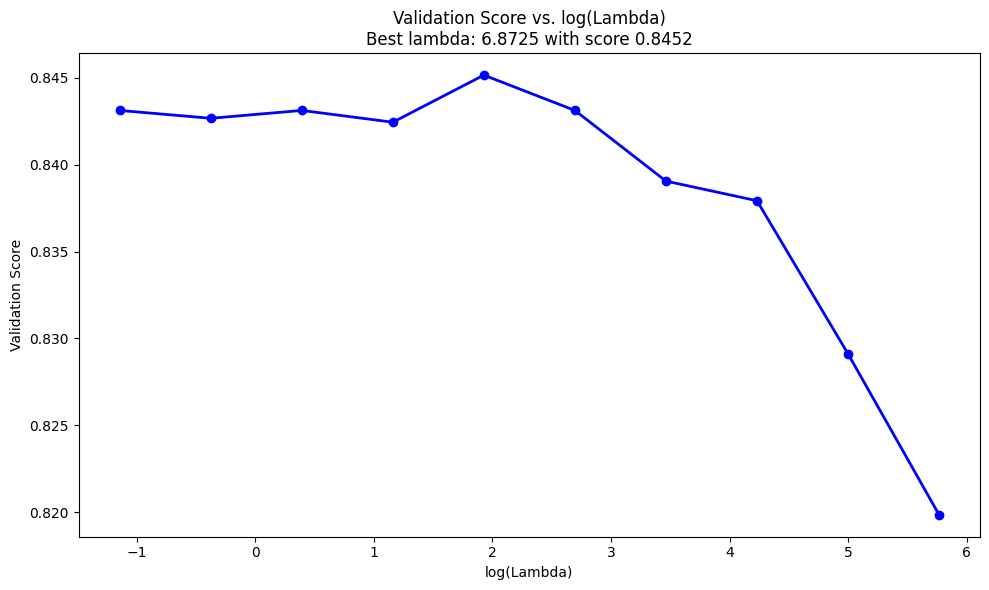

(6.872474181478272, 0.8451627486437613)

In [27]:
logRegCCD.plot_score()

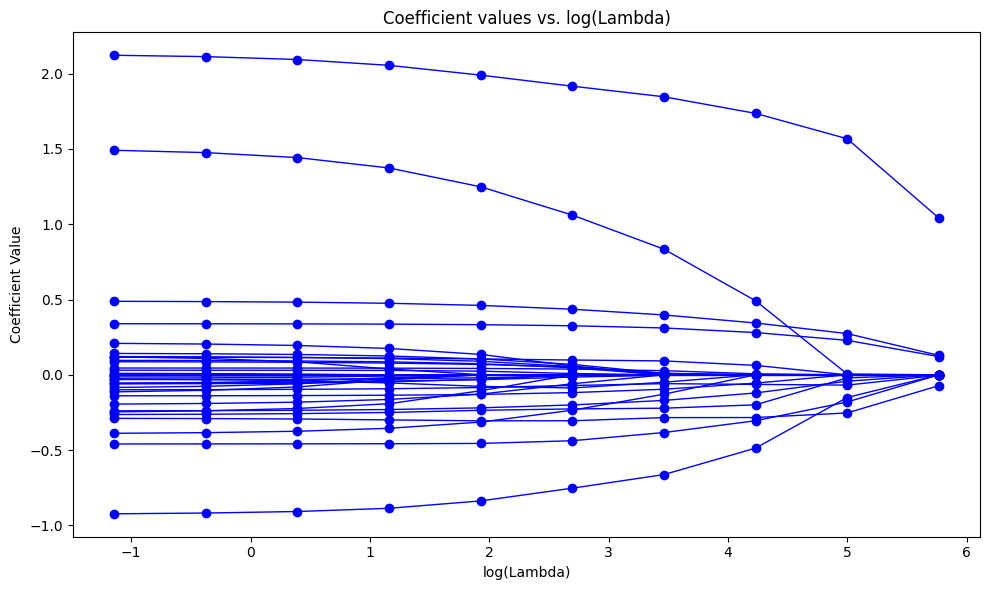

In [28]:
logRegCCD.plot_coeff()

In [30]:
clf = LogisticRegression(random_state=42, penalty='none').fit(student_dropout_X, student_dropout_y)
print("Accuracy: ", clf.score(student_dropout_X, student_dropout_y))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)

Accuracy:  0.8099005424954792
Beta:  [[ 0.00252649 -0.01502113  0.00328607 -0.00048397 -0.00414482 -0.00341926
  -0.00419997 -0.00653136  0.0049818   0.01379664  0.00218588 -0.00437869
   0.0046178  -0.00041298 -0.00030078 -0.01214245  0.01598271 -0.01500349
   0.02100519 -0.04674444  0.00033011 -0.00851891  0.01183921 -0.0775881
   0.16504108  0.17149663 -0.00690899 -0.00431921  0.01443085 -0.08085689
   0.20846432  0.23149465 -0.00928736  0.00240969 -0.00562506  0.00371382]]
Beta zero:  [-0.00151783]
